# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files

**Date**: October 7th 2025

**Student Name**: Luis Daniel Arellano Núñez

**Professor**: Pablo Camarillo Ramirez

# Create Spark Session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Lab 7") \
    .master("spark://8c99a6c586f5:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/10 00:13:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!ls ../../data/lab7_logs/
!pwd

logs_batch_0.log  logs_batch_1.log  logs_batch_2.log
/opt/spark/work-dir/labs/lab07


In [ ]:
from Daniel_Arellano.sql_im import SparkUtils
from pyspark.sql.functions import split, col

logs_schema = SparkUtils.generate_schema([("date", "timestamp"), ("state", "string"), ("desc","string"), ("node","string")])

logs_df_raw = spark.readStream \
    .format("text") \
    .load("/opt/spark/work-dir/data/lab7_logs/")

logs_df = logs_df_raw.select(
    split(col("value"), " \\| ").alias("parts")
).select(
    col("parts").getItem(0).alias("date").cast("timestamp"),
    col("parts").getItem(1).alias("state"),
    col("parts").getItem(2).alias("desc"),
    col("parts").getItem(3).alias("node")
).filter(col("state") == "ERROR")

query = logs_df.writeStream \
            .outputMode("append") \
            .format("console") \
            .start()

query.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+----+----+
|date|state|desc|node|
+----+-----+----+----+
+----+-----+----+----+

-------------------------------------------
Batch: 1
-------------------------------------------
+-------------------+-----+--------------------+-------------+
|               date|state|                desc|         node|
+-------------------+-----+--------------------+-------------+
|2025-10-09 18:45:29|ERROR|503 System Tempor...|server-node-3|
|2025-10-09 18:50:29|ERROR|500 Internal Serv...|server-node-1|
+-------------------+-----+--------------------+-------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+-------------------+-----+--------------------+-------------+
|               date|state|                desc|         node|
+-------------------+-----+--------------------+-------------+
|2025-10-09 19:05:29|ERROR|500 Internal Serv...|

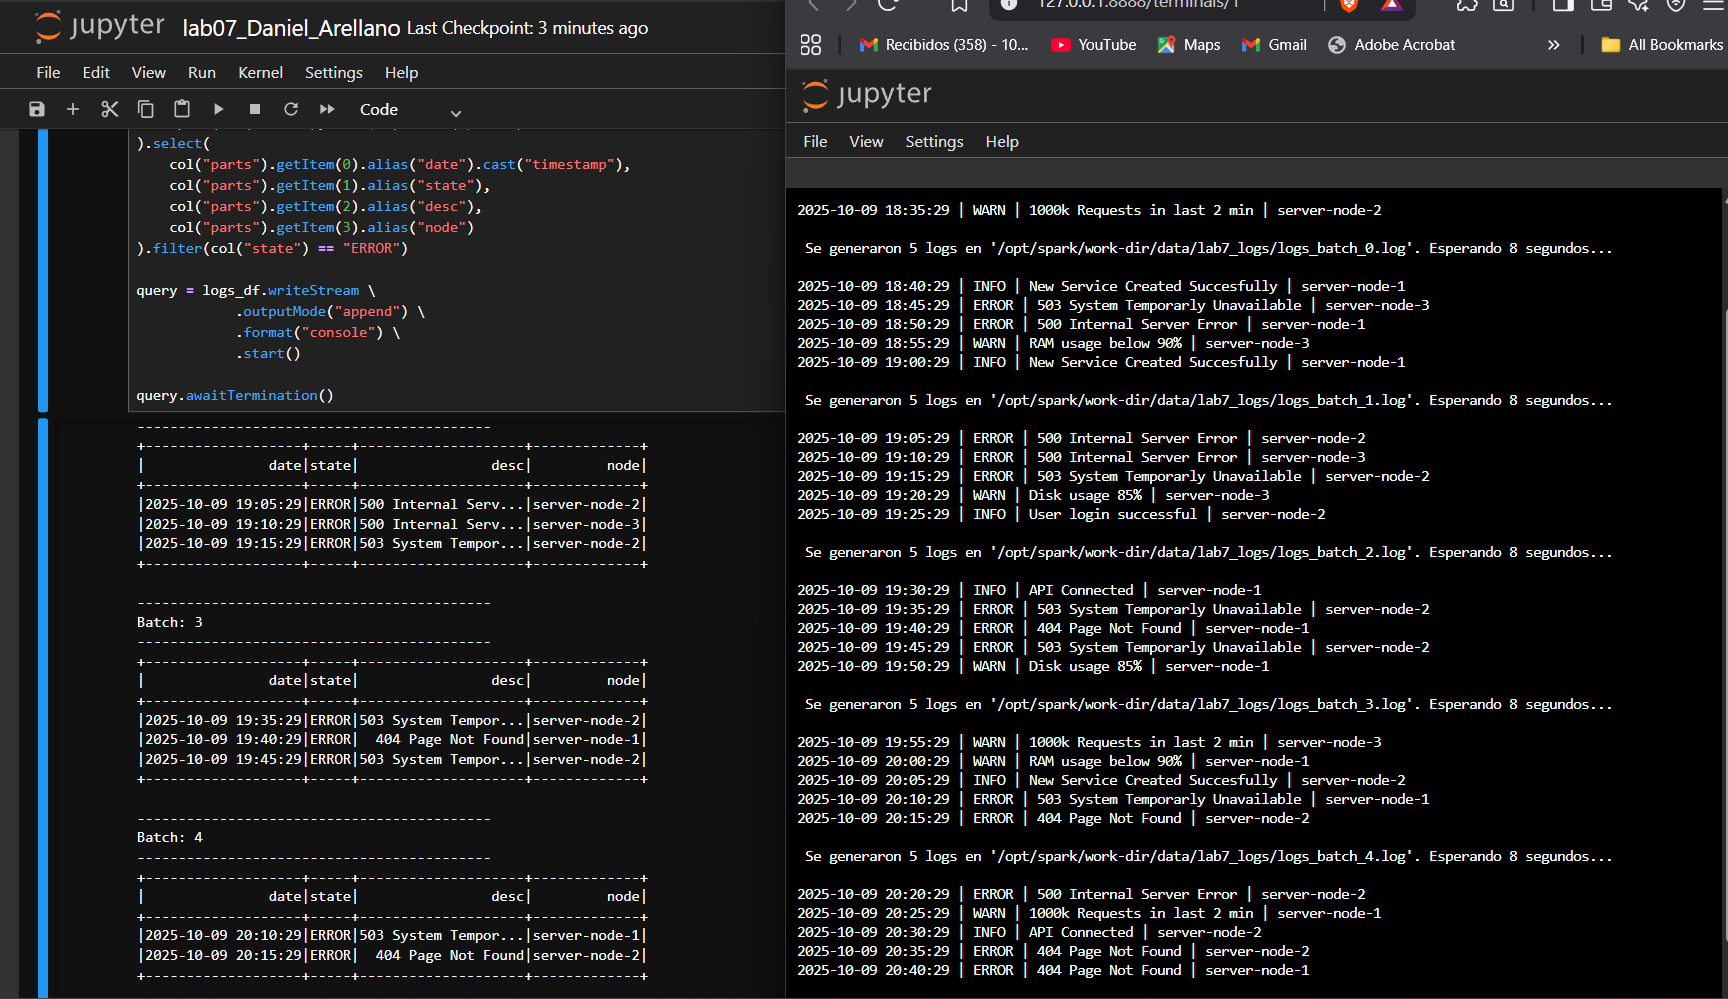

In [ ]:
query.stop()

In [15]:
sc.stop()